In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 60
PREDICTION_AFTER_DAYS = 2
EPOCHS = 200
TEST_SIZE = 0.05
RANDOM_SPLIT = False

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [3]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

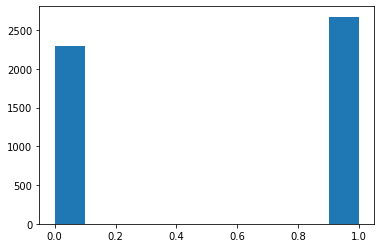

1    2671
0    2297
dtype: int64

In [4]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [5]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 8)            

In [6]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4719, 60, 5), (4719,), (249, 60, 5), (249,))

In [44]:
import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

In [45]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="model-binary.hdf5", save_best_only=True)

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [checkpointer])

Train on 4388 samples, validate on 249 samples
Epoch 1/200
4388/4388 [==============================] - 0s 82us/step - loss: 0.6923 - tp: 1577.0000 - fp: 1488.0000 - tn: 706.0000 - fn: 617.0000 - accuracy: 0.5203 - precision: 0.5145 - recall: 0.7188 - auc: 0.5263 - val_loss: 0.6908 - val_tp: 129.0000 - val_fp: 95.0000 - val_tn: 8.0000 - val_fn: 17.0000 - val_accuracy: 0.5502 - val_precision: 0.5759 - val_recall: 0.8836 - val_auc: 0.4533
Epoch 2/200
4388/4388 [==============================] - 0s 76us/step - loss: 0.6913 - tp: 1322.0000 - fp: 1182.0000 - tn: 1012.0000 - fn: 872.0000 - accuracy: 0.5319 - precision: 0.5280 - recall: 0.6026 - auc: 0.5383 - val_loss: 0.7375 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_fn: 146.0000 - val_accuracy: 0.4137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4618
Epoch 3/200
4388/4388 [==============================] - 0s 84us/step - loss: 0.6914 - tp: 1184.0000 - fp: 1059.0000 - tn: 1135.0000 - fn: 1010.0000

4388/4388 [==============================] - 0s 64us/step - loss: 0.6911 - tp: 1167.0000 - fp: 1032.0000 - tn: 1162.0000 - fn: 1027.0000 - accuracy: 0.5308 - precision: 0.5307 - recall: 0.5319 - auc: 0.5415 - val_loss: 0.6939 - val_tp: 75.0000 - val_fp: 54.0000 - val_tn: 49.0000 - val_fn: 71.0000 - val_accuracy: 0.4980 - val_precision: 0.5814 - val_recall: 0.5137 - val_auc: 0.5045
Epoch 22/200
4388/4388 [==============================] - 0s 63us/step - loss: 0.6937 - tp: 1114.0000 - fp: 991.0000 - tn: 1203.0000 - fn: 1080.0000 - accuracy: 0.5280 - precision: 0.5292 - recall: 0.5077 - auc: 0.5393 - val_loss: 0.6993 - val_tp: 24.0000 - val_fp: 17.0000 - val_tn: 86.0000 - val_fn: 122.0000 - val_accuracy: 0.4418 - val_precision: 0.5854 - val_recall: 0.1644 - val_auc: 0.5032
Epoch 23/200
4388/4388 [==============================] - 0s 66us/step - loss: 0.6918 - tp: 1113.0000 - fp: 1004.0000 - tn: 1190.0000 - fn: 1081.0000 - accuracy: 0.5248 - precision: 0.5257 - recall: 0.5073 - auc: 0.5328

4388/4388 [==============================] - 0s 67us/step - loss: 0.6884 - tp: 1228.0000 - fp: 1050.0000 - tn: 1144.0000 - fn: 966.0000 - accuracy: 0.5406 - precision: 0.5391 - recall: 0.5597 - auc: 0.5545 - val_loss: 0.6846 - val_tp: 146.0000 - val_fp: 103.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5863 - val_precision: 0.5863 - val_recall: 1.0000 - val_auc: 0.5341
Epoch 42/200
4388/4388 [==============================] - 0s 66us/step - loss: 0.6893 - tp: 1153.0000 - fp: 1054.0000 - tn: 1140.0000 - fn: 1041.0000 - accuracy: 0.5226 - precision: 0.5224 - recall: 0.5255 - auc: 0.5447 - val_loss: 0.6796 - val_tp: 146.0000 - val_fp: 103.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5863 - val_precision: 0.5863 - val_recall: 1.0000 - val_auc: 0.5070
Epoch 43/200
4388/4388 [==============================] - 0s 67us/step - loss: 0.6916 - tp: 1197.0000 - fp: 1082.0000 - tn: 1112.0000 - fn: 997.0000 - accuracy: 0.5262 - precision: 0.5252 - recall: 0.5456

4388/4388 [==============================] - 0s 66us/step - loss: 0.6899 - tp: 1221.0000 - fp: 1056.0000 - tn: 1138.0000 - fn: 973.0000 - accuracy: 0.5376 - precision: 0.5362 - recall: 0.5565 - auc: 0.5476 - val_loss: 0.6836 - val_tp: 144.0000 - val_fp: 103.0000 - val_tn: 0.0000e+00 - val_fn: 2.0000 - val_accuracy: 0.5783 - val_precision: 0.5830 - val_recall: 0.9863 - val_auc: 0.5050
Epoch 62/200
4388/4388 [==============================] - 0s 64us/step - loss: 0.6909 - tp: 1193.0000 - fp: 1081.0000 - tn: 1113.0000 - fn: 1001.0000 - accuracy: 0.5255 - precision: 0.5246 - recall: 0.5438 - auc: 0.5392 - val_loss: 0.6784 - val_tp: 146.0000 - val_fp: 103.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5863 - val_precision: 0.5863 - val_recall: 1.0000 - val_auc: 0.5140
Epoch 63/200
4388/4388 [==============================] - 0s 63us/step - loss: 0.6879 - tp: 1124.0000 - fp: 954.0000 - tn: 1240.0000 - fn: 1070.0000 - accuracy: 0.5387 - precision: 0.5409 - recall: 0.5123 - a

4388/4388 [==============================] - 0s 70us/step - loss: 0.6905 - tp: 1233.0000 - fp: 1080.0000 - tn: 1114.0000 - fn: 961.0000 - accuracy: 0.5349 - precision: 0.5331 - recall: 0.5620 - auc: 0.5414 - val_loss: 0.6897 - val_tp: 116.0000 - val_fp: 88.0000 - val_tn: 15.0000 - val_fn: 30.0000 - val_accuracy: 0.5261 - val_precision: 0.5686 - val_recall: 0.7945 - val_auc: 0.4916
Epoch 82/200
4388/4388 [==============================] - 0s 68us/step - loss: 0.6909 - tp: 1117.0000 - fp: 978.0000 - tn: 1216.0000 - fn: 1077.0000 - accuracy: 0.5317 - precision: 0.5332 - recall: 0.5091 - auc: 0.5434 - val_loss: 0.7163 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_fn: 146.0000 - val_accuracy: 0.4137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4886
Epoch 83/200
4388/4388 [==============================] - 0s 69us/step - loss: 0.6913 - tp: 1347.0000 - fp: 1231.0000 - tn: 963.0000 - fn: 847.0000 - accuracy: 0.5264 - precision: 0.5225 - recall: 0.6139 

4388/4388 [==============================] - 0s 70us/step - loss: 0.6935 - tp: 1037.0000 - fp: 1016.0000 - tn: 1178.0000 - fn: 1157.0000 - accuracy: 0.5048 - precision: 0.5051 - recall: 0.4727 - auc: 0.5144 - val_loss: 0.6961 - val_tp: 75.0000 - val_fp: 54.0000 - val_tn: 49.0000 - val_fn: 71.0000 - val_accuracy: 0.4980 - val_precision: 0.5814 - val_recall: 0.5137 - val_auc: 0.4889
Epoch 102/200
4388/4388 [==============================] - 0s 68us/step - loss: 0.6914 - tp: 1112.0000 - fp: 981.0000 - tn: 1213.0000 - fn: 1082.0000 - accuracy: 0.5299 - precision: 0.5313 - recall: 0.5068 - auc: 0.5412 - val_loss: 0.6847 - val_tp: 141.0000 - val_fp: 99.0000 - val_tn: 4.0000 - val_fn: 5.0000 - val_accuracy: 0.5823 - val_precision: 0.5875 - val_recall: 0.9658 - val_auc: 0.4980
Epoch 103/200
4388/4388 [==============================] - 0s 69us/step - loss: 0.6923 - tp: 1181.0000 - fp: 1097.0000 - tn: 1097.0000 - fn: 1013.0000 - accuracy: 0.5191 - precision: 0.5184 - recall: 0.5383 - auc: 0.5325

4388/4388 [==============================] - 0s 70us/step - loss: 0.6913 - tp: 1167.0000 - fp: 1051.0000 - tn: 1143.0000 - fn: 1027.0000 - accuracy: 0.5264 - precision: 0.5261 - recall: 0.5319 - auc: 0.5364 - val_loss: 0.6880 - val_tp: 146.0000 - val_fp: 103.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5863 - val_precision: 0.5863 - val_recall: 1.0000 - val_auc: 0.4932
Epoch 122/200
4388/4388 [==============================] - 0s 68us/step - loss: 0.6899 - tp: 1101.0000 - fp: 959.0000 - tn: 1235.0000 - fn: 1093.0000 - accuracy: 0.5324 - precision: 0.5345 - recall: 0.5018 - auc: 0.5436 - val_loss: 0.7118 - val_tp: 3.0000 - val_fp: 1.0000 - val_tn: 102.0000 - val_fn: 143.0000 - val_accuracy: 0.4217 - val_precision: 0.7500 - val_recall: 0.0205 - val_auc: 0.4761
Epoch 123/200
4388/4388 [==============================] - 0s 69us/step - loss: 0.6912 - tp: 1099.0000 - fp: 980.0000 - tn: 1214.0000 - fn: 1095.0000 - accuracy: 0.5271 - precision: 0.5286 - recall: 0.5009 - auc

4388/4388 [==============================] - 0s 69us/step - loss: 0.6908 - tp: 1113.0000 - fp: 1013.0000 - tn: 1181.0000 - fn: 1081.0000 - accuracy: 0.5228 - precision: 0.5235 - recall: 0.5073 - auc: 0.5394 - val_loss: 0.7094 - val_tp: 12.0000 - val_fp: 11.0000 - val_tn: 92.0000 - val_fn: 134.0000 - val_accuracy: 0.4177 - val_precision: 0.5217 - val_recall: 0.0822 - val_auc: 0.5049
Epoch 142/200
4388/4388 [==============================] - 0s 67us/step - loss: 0.6894 - tp: 1116.0000 - fp: 939.0000 - tn: 1255.0000 - fn: 1078.0000 - accuracy: 0.5403 - precision: 0.5431 - recall: 0.5087 - auc: 0.5559 - val_loss: 0.7057 - val_tp: 11.0000 - val_fp: 7.0000 - val_tn: 96.0000 - val_fn: 135.0000 - val_accuracy: 0.4297 - val_precision: 0.6111 - val_recall: 0.0753 - val_auc: 0.4991
Epoch 143/200
4388/4388 [==============================] - 0s 68us/step - loss: 0.6903 - tp: 1204.0000 - fp: 1033.0000 - tn: 1161.0000 - fn: 990.0000 - accuracy: 0.5390 - precision: 0.5382 - recall: 0.5488 - auc: 0.544

4388/4388 [==============================] - 0s 69us/step - loss: 0.6886 - tp: 1171.0000 - fp: 1027.0000 - tn: 1167.0000 - fn: 1023.0000 - accuracy: 0.5328 - precision: 0.5328 - recall: 0.5337 - auc: 0.5526 - val_loss: 0.6881 - val_tp: 146.0000 - val_fp: 103.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5863 - val_precision: 0.5863 - val_recall: 1.0000 - val_auc: 0.4912
Epoch 162/200
4388/4388 [==============================] - 0s 69us/step - loss: 0.6893 - tp: 1053.0000 - fp: 940.0000 - tn: 1254.0000 - fn: 1141.0000 - accuracy: 0.5258 - precision: 0.5283 - recall: 0.4799 - auc: 0.5468 - val_loss: 0.7387 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_fn: 146.0000 - val_accuracy: 0.4137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4671
Epoch 163/200
4388/4388 [==============================] - 0s 67us/step - loss: 0.6896 - tp: 1188.0000 - fp: 1044.0000 - tn: 1150.0000 - fn: 1006.0000 - accuracy: 0.5328 - precision: 0.5323 - rec

4388/4388 [==============================] - 0s 68us/step - loss: 0.6875 - tp: 1214.0000 - fp: 1025.0000 - tn: 1169.0000 - fn: 980.0000 - accuracy: 0.5431 - precision: 0.5422 - recall: 0.5533 - auc: 0.5592 - val_loss: 0.6809 - val_tp: 142.0000 - val_fp: 101.0000 - val_tn: 2.0000 - val_fn: 4.0000 - val_accuracy: 0.5783 - val_precision: 0.5844 - val_recall: 0.9726 - val_auc: 0.4899
Epoch 182/200
4388/4388 [==============================] - 0s 69us/step - loss: 0.6886 - tp: 1249.0000 - fp: 1069.0000 - tn: 1125.0000 - fn: 945.0000 - accuracy: 0.5410 - precision: 0.5388 - recall: 0.5693 - auc: 0.5537 - val_loss: 0.8053 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_fn: 146.0000 - val_accuracy: 0.4137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4854
Epoch 183/200
4388/4388 [==============================] - 0s 69us/step - loss: 0.6873 - tp: 1258.0000 - fp: 1082.0000 - tn: 1112.0000 - fn: 936.0000 - accuracy: 0.5401 - precision: 0.5376 - recall: 0.573

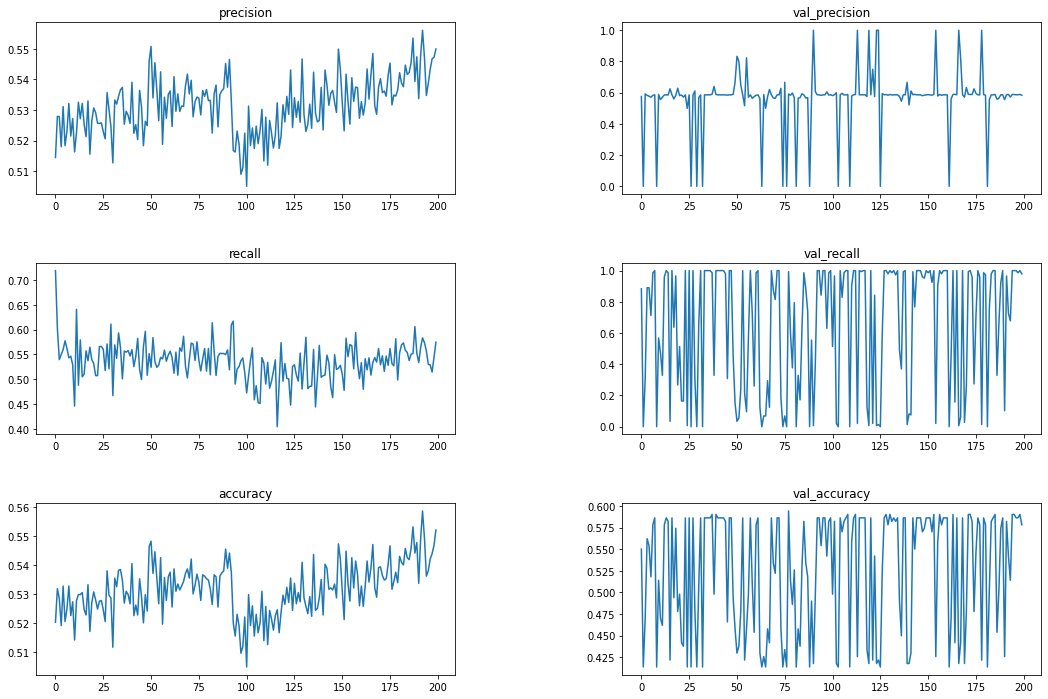

In [46]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()